# Emotion Recognition and Classification in Speech

## Dataset Preparation and Loading

In [2]:
import os
import pandas as pd

def create_ravdess_map_df():
    file_paths = []
    emotions = []
    
    for root, dirs, files in os.walk("Audio_Speech_Actors_01-24"):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                emotion_code = int(file.split('-')[2])
                emotion_map = {1: "neutral", 2: "calm", 3: "happy", 4: "sad", 5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"}
                emotion = emotion_map[emotion_code]
                
                file_paths.append(file_path)
                emotions.append(emotion)
    
    df = pd.DataFrame({"file_path": file_paths, "emotion": emotions})
    df.to_csv("ravdess_metadata.csv", index=False)
    print(f"Dataset prepared with {len(df)} audio files.")
    return df

In [6]:
ravdess_df = create_ravdess_map_df()

Dataset prepared with 1440 audio files.


In [7]:
from faster_whisper import WhisperModel
import pandas as pd
import json
import os
import torch

def add_transcripts_to_ravdess(df, output_dir="transcripts", model_size="distil-large-v3"):
    os.makedirs(output_dir, exist_ok=True)
    
    transcripts = []
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = WhisperModel(model_size, device=device, compute_type="float16" if torch.cuda.is_available() else "float32")

    for idx, row in df.iterrows():
        file_path = row["file_path"]
        emotion = row["emotion"]
        
        output_file = os.path.join(output_dir, f"{os.path.basename(file_path).split('.')[0]}.json")
        
        if os.path.exists(output_file):
            print(f"Transcript exists for {file_path}")
            with open(output_file, 'r') as f:
                transcript_data = json.load(f)
            transcript_text = transcript_data["text"]
        else:
            print(f"Processing {file_path}...")
            
            try:
                segments, info = model.transcribe(file_path, beam_size=5, language="en", condition_on_previous_text=False)
                transcript_text = " ".join([segment.text for segment in segments])
                transcript_data = {"text": transcript_text}
                with open(output_file, 'w') as f:
                    json.dump(transcript_data, f)
            
            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")
                transcript_text = ""
        
        transcripts.append({
            "file_path": file_path,
            "emotion": emotion,
            "transcript": transcript_text
        })
    
    return pd.DataFrame(transcripts)

In [8]:
transcripts_df = add_transcripts_to_ravdess(ravdess_df)

Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-01-01-01-01-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-01-01-01-02-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-01-01-02-01-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-01-01-02-02-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-01-01-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-01-02-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-02-01-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-02-02-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-02-02-01-01-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-02-02-01-02-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-02-02-02-01-01.wav
Transcript exists for Audio_Speech_Actors_01-24\Actor_01\03-01-02-02-02-02-01.wav
Transcript exist

### Extracting Audio Features

In [ ]:
import librosa
import numpy as np
import torch

def extract_audio_features(file_path, max_length=128000, sr=16000, n_mfcc=13, n_mels=128):
    """Extract audio features (MFCC and Mel spectrogram) from an audio file"""
    audio, _ = librosa.load(file_path, sr=sr)
    
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), 'constant')
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec)
    
    mfccs = (mfccs - np.mean(mfccs)) / (np.std(mfccs) + 1e-8)
    log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / (np.std(log_mel_spec) + 1e-8)
    
    features = {
        'mfccs': mfccs,
        'log_mel_spec': log_mel_spec
    }
    
    return features

def prepare_dataset_features(df):
    """Extract features for all audio files in the dataset"""
    audio_features = []
    
    for idx, row in df.iterrows():
        file_path = row["file_path"]
        emotion = row["emotion"]
        transcript = row["transcript"]
        
        features = extract_audio_features(file_path)
        
        audio_features.append({
            "file_path": file_path,
            "emotion": emotion,
            "transcript": transcript,
            "mfccs": features["mfccs"],
            "log_mel_spec": features["log_mel_spec"]
        })
    
    return audio_features

In [ ]:
from transformers import BertTokenizer, BertModel

def extract_text_features(transcripts, max_length=64):
    """Extract text features using BERT"""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()
    
    text_features = []
    
    for transcript in transcripts:
        inputs = tokenizer(transcript, return_tensors="pt", max_length=max_length, 
                          padding="max_length", truncation=True)
        
        with torch.no_grad():
            outputs = model(**inputs)
        text_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        text_features.append(text_embedding[0])
    
    return np.array(text_features)




In [11]:
# Extract features
dataset_features = prepare_dataset_features(transcripts_df)

# Save features
import pickle
with open('ravdess_features.pkl', 'wb') as f:
    pickle.dump(dataset_features, f)

# Extract text features
transcripts = transcripts_df["transcript"].tolist()
text_features = extract_text_features(transcripts)

# Save text features
np.save('ravdess_text_features.npy', text_features)

### Collating final dataset

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

class EmotionDataset(Dataset):
    """Dataset for multimodal emotion recognition"""
    def __init__(self, features, text_features, transform=None):
        self.features = features
        self.text_features = text_features
        self.transform = transform
        
        self.emotions = [item["emotion"] for item in features]
        self.label_encoder = LabelEncoder()
        self.encoded_emotions = self.label_encoder.fit_transform(self.emotions)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        audio_feature = self.features[idx]["log_mel_spec"]
        text_feature = self.text_features[idx]
        emotion = self.encoded_emotions[idx]
        
        audio_tensor = torch.FloatTensor(audio_feature).unsqueeze(0)
        text_tensor = torch.FloatTensor(text_feature)
        emotion_tensor = torch.tensor(emotion, dtype=torch.long)
        
        if self.transform:
            audio_tensor = self.transform(audio_tensor)
        
        return {
            "audio": audio_tensor,
            "text": text_tensor,
            "emotion": emotion_tensor
        }

In [13]:
emotion_dataset = EmotionDataset(dataset_features, text_features)

from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(
    list(range(len(emotion_dataset))), 
    test_size=0.2, 
    random_state=42,
    stratify=[item["emotion"] for item in dataset_features]
)

In [14]:
from torch.utils.data import Subset

train_dataset = Subset(emotion_dataset, train_indices)
val_dataset = Subset(emotion_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Creating Model Architecture

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioEncoder(nn.Module):
    """Audio encoder with fixed dimensions"""
    def __init__(self, input_channels=1, hidden_dim=64):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.fc = nn.Linear(64 * 4 * 4, hidden_dim)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x


class TextEncoder(nn.Module):
    """Text encoder for emotion recognition"""
    def __init__(self, input_dim=768, hidden_dim=64):
        super(TextEncoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        return x

class EmotionClassifier(nn.Module):
    """Multimodal emotion classifier using audio and text features"""
    def __init__(self, num_emotions=8, audio_hidden_dim=64, text_hidden_dim=64, fusion_dim=128):
        super(EmotionClassifier, self).__init__()
        
        self.audio_encoder = AudioEncoder(hidden_dim=audio_hidden_dim)
        self.text_encoder = TextEncoder(hidden_dim=text_hidden_dim)
        self.fusion = nn.Sequential(
            nn.Linear(audio_hidden_dim + text_hidden_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_dim, num_emotions)
        )
        
    def forward(self, audio, text):
        audio_features = self.audio_encoder(audio)
        text_features = self.text_encoder(text)
        combined_features = torch.cat((audio_features, text_features), dim=1)
        output = self.fusion(combined_features)
        return output

## Training the model

In [17]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_model(model, train_loader, val_loader, dataset, num_epochs=100, learning_rate=0.001):
    """Train the emotion classification model"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_true = []
        
        for batch in train_loader:
            audio = batch["audio"].to(device)
            text = batch["text"].to(device)
            emotions = batch["emotion"].to(device)
            
            outputs = model(audio, text)
            loss = criterion(outputs, emotions)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_true.extend(emotions.cpu().numpy())
        
        train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_true, train_preds)
        train_f1 = f1_score(train_true, train_preds, average='weighted')
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for batch in val_loader:
                audio = batch["audio"].to(device)
                text = batch["text"].to(device)
                emotions = batch["emotion"].to(device)
                
                outputs = model(audio, text)
                loss = criterion(outputs, emotions)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_true.extend(emotions.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds, average='weighted')
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_emotion_model.pt")
            print("Saved best model!")

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("training_history.png")
    
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch in val_loader:
            audio = batch["audio"].to(device)
            text = batch["text"].to(device)
            emotions = batch["emotion"].to(device)
            
            outputs = model(audio, text)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(emotions.cpu().numpy())
    
    cm = confusion_matrix(all_true, all_preds)
    emotion_labels = dataset.label_encoder.classes_
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    
    return model

In [19]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_model_es(model, train_loader, val_loader, dataset, num_epochs=100, learning_rate=0.001, patience=5, delta=0.001):
    """Train the emotion classification model with early stopping"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    no_improvement_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_true = []
        
        for batch in train_loader:
            audio = batch["audio"].to(device)
            text = batch["text"].to(device)
            emotions = batch["emotion"].to(device)
            
            outputs = model(audio, text)
            loss = criterion(outputs, emotions)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_true.extend(emotions.cpu().numpy())
        
        train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_true, train_preds)
        train_f1 = f1_score(train_true, train_preds, average='weighted')
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for batch in val_loader:
                audio = batch["audio"].to(device)
                text = batch["text"].to(device)
                emotions = batch["emotion"].to(device)
                
                outputs = model(audio, text)
                loss = criterion(outputs, emotions)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_true.extend(emotions.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds, average='weighted')
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        if val_acc > (best_val_acc + delta):
            print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}")
            best_val_acc = val_acc
            model_name = f"model_{val_acc:.4f}_no_augmentation_{epoch+1}.pt"
            torch.save(model.state_dict(), model_name)
            print(f"Saved best model as {model_name}!")
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            print(f"No improvement for {no_improvement_counter}/{patience} epochs")
            if no_improvement_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("training_history.png")
    
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch in val_loader:
            audio = batch["audio"].to(device)
            text = batch["text"].to(device)
            emotions = batch["emotion"].to(device)
            
            outputs = model(audio, text)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(emotions.cpu().numpy())
    
    cm = confusion_matrix(all_true, all_preds)
    emotion_labels = dataset.label_encoder.classes_
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    
    return model

Using device: cuda:0
Epoch 1/200
Train Loss: 2.0701, Train Acc: 0.1215, Train F1: 0.1052
Val Loss: 2.0486, Val Acc: 0.1806, Val F1: 0.0868
Saved best model!
Epoch 2/200
Train Loss: 2.0266, Train Acc: 0.1797, Train F1: 0.1400
Val Loss: 1.9770, Val Acc: 0.1840, Val F1: 0.0877
Saved best model!
Epoch 3/200
Train Loss: 1.9751, Train Acc: 0.1936, Train F1: 0.1754
Val Loss: 1.9113, Val Acc: 0.3090, Val F1: 0.2859
Saved best model!
Epoch 4/200
Train Loss: 1.8890, Train Acc: 0.2439, Train F1: 0.2356
Val Loss: 1.8368, Val Acc: 0.3264, Val F1: 0.2812
Saved best model!
Epoch 5/200
Train Loss: 1.7838, Train Acc: 0.3003, Train F1: 0.2786
Val Loss: 1.7187, Val Acc: 0.3125, Val F1: 0.2744
Epoch 6/200
Train Loss: 1.7390, Train Acc: 0.3420, Train F1: 0.3231
Val Loss: 1.6710, Val Acc: 0.3438, Val F1: 0.3151
Saved best model!
Epoch 7/200
Train Loss: 1.6822, Train Acc: 0.3420, Train F1: 0.3187
Val Loss: 1.6660, Val Acc: 0.3472, Val F1: 0.3359
Saved best model!
Epoch 8/200
Train Loss: 1.6289, Train Acc: 0.

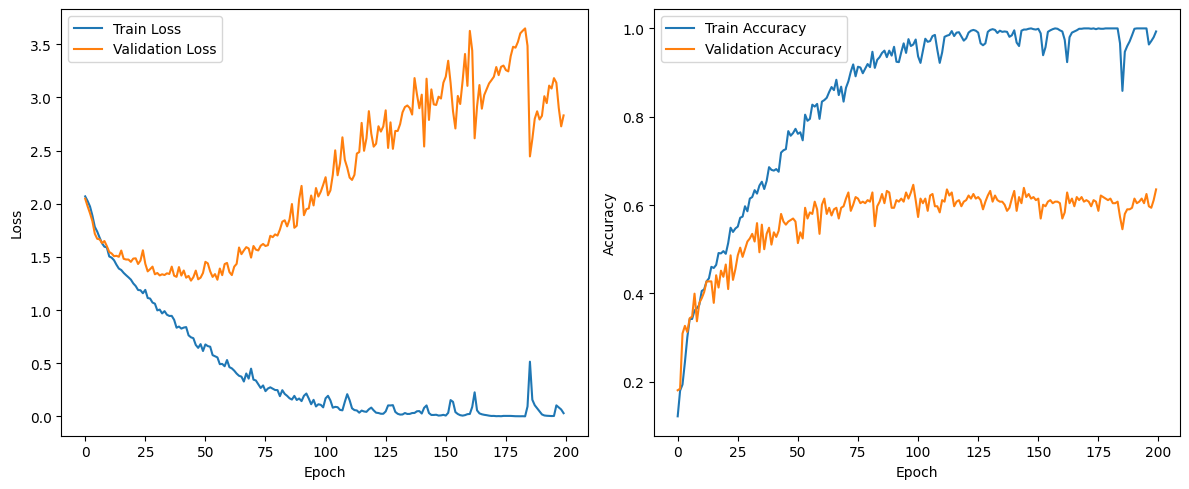

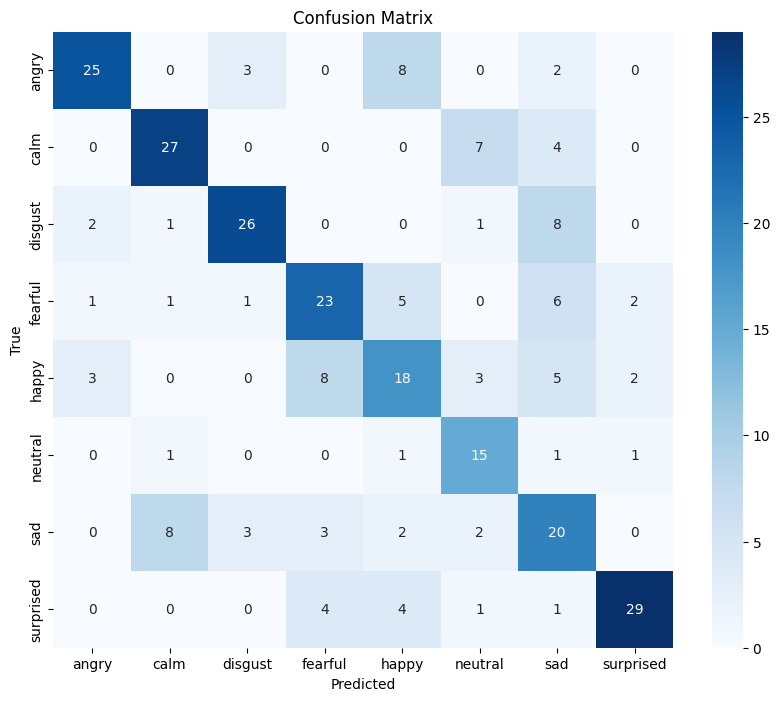

In [18]:
num_emotions = len(emotion_dataset.label_encoder.classes_)
model = EmotionClassifier(num_emotions=num_emotions)

trained_model = train_model(model, train_loader, val_loader, emotion_dataset, num_epochs=200)